In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
# from sklearn.preprocessing import label_binarize
# from sklearn import preprocessing
# from sklearn import tree 

import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import scipy.io as scio
# import hiddenlayer as h
from visdom import Visdom
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from torchviz import make_dot

import datetime
import os 

import sys
from utils.reuse import *
from utils.networks import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
# 构建 loss 时需要注意所有的 tensor 操作都应该在 torch 工具包里面出现，
# 当然了基本的加减乘除不用，参考：https://blog.csdn.net/bornfree5511/
# article/details/104118437?utm_medium=distribute.pc_relevant.
# none-task-blog-2~default~baidujs_title~default-0.pc_relevant_aa&spm
# =1001.2101.3001.4242.1&utm_relevant_index=3，
# 当然我已经将它复制到一个 excel 并转为 pdf 永久保存了，看哪个都一样
class LossMSE2(nn.Module):
    def __init__ (self):
        super(LossMSE2,self).__init__()
        self.Loss_MSE = torch.nn.MSELoss()

    def forward(self,s_ma,s_cv,s_g,s_m_ar,s_m_ab,preds,s_y):
        p1,p2 = torch.chunk(preds,2,1)
        new_loss = s_ma + s_cv + s_g - \
            (p1 * s_m_ar) - (p2 * s_m_ab)
        old_loss = self.Loss_MSE(preds,s_y)
        loss = new_loss+old_loss

        return loss
# 引入角度后的新损失函数
class LossMSE3(nn.Module):
    def __init__ (self):
        super(LossMSE3,self).__init__()
        self.Loss_MSE = torch.nn.MSELoss()
        # self.v_0 = torch.zeros([1]).to(device)
        # self.a_0 = torch.zeros([1]).to(device)
        # self.a_1 = torch.zeros([1]).to(device)
        self.v_0 = 0
        self.a_0 = 0
        self.a_1 = 0
        self.pred_angle_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
        self.time_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
        self.vel_list = [torch.tensor([],requires_grad=False) \
        for i in range(81)]

    def forward(self,preds,s_y,s_cyc,s_time,s_m_ar,s_m_ab,):
        # p1,肌肉力 rf , p2,肌肉力 bm, p3, 关节角度
        p1,p2,p3 = torch.chunk(preds,3,1)
        s_v = 0
        s_a = 0
        s_time.requires_grad_(False)
        s_m_ar.requires_grad_(False)
        s_m_ab.requires_grad_(False)
        s_cyc.requires_grad_(False)

        if s_cyc == 0:
            s_v = self.v_0
            s_a = self.a_0
            p_a = p3
            p_a.detach()
            self.pred_angle_list[int(s_cyc)] = p_a
            s_tt = s_time
            s_tt.requires_grad_(False)
            self.time_list[int(s_cyc)] = s_tt
            s_vv = s_v
            self.vel_list[int(s_cyc)] = s_vv
        elif s_cyc == 1:
            s_a = self.a_1
            p_a = p3
            p_a.detach()
            self.pred_angle_list[int(s_cyc)] = p_a
            s_tt = s_time
            s_tt.detach()
            s_time.requires_grad_(False)
            self.time_list[int(s_cyc)] = s_tt
            s_time_p = self.time_list[int(s_cyc)-1]
            s_angle_p = self.pred_angle_list[int(s_cyc)-1]
            s_v = (p3 - s_angle_p.to(device)) / (s_time.to(device) - s_time_p.to(device))
            self.vel_list[int(s_cyc)] = s_v
        else:
            # 当前值存入列表备用，同时取出前一刻角度值计算速度与加速度
            p_a = p3
            p_a.detach()
            self.pred_angle_list[int(s_cyc)] = p_a
            s_tt = s_time
            s_tt.detach()
            self.time_list[int(s_cyc)] = s_tt
            s_angle_p = self.pred_angle_list[int(s_cyc)-1]
            s_time_p = self.time_list[int(s_cyc)-1]
            s_v = (p3 - s_angle_p.to(device)) / (s_time.to(device) - s_time_p.to(device))
            s_vv = s_v
            self.vel_list[int(s_cyc)] = s_vv
            s_v_p = self.vel_list[int(s_cyc)-1]
            s_a = (s_v - s_v_p.to(device))/ (s_time.to(device) - s_time_p.to(device))



        M_knee = 0.054596 *5.74*0.174*0.174
        C_knee = 5.74*0.174*0.4*torch.sin(p3/360*2*np.pi)
        G_theta = 5.74*9.8*0.174*0.174*torch.cos(p3/360*2*np.pi)


        new_loss = M_knee * s_a + C_knee.to(device) * s_v+ G_theta.to(device) * p3.to(device) - \
            (p1.to(device) * s_m_ar.to(device)) - (p2.to(device) * s_m_ab.to(device))
        old_loss = self.Loss_MSE(preds,s_y)
        loss = new_loss+old_loss

        return loss
new_loss2 = LossMSE2()
new_loss3 = LossMSE3()

In [12]:
emg_vec = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
time_vec = [torch.tensor([],requires_grad=False) \
        for i in range(81)]
# print(emg_vec._version)
emg_vec[0] = torch.tensor(1)
preds = torch.randn([1,3],requires_grad=True)
s_y = torch.ones([1,3])
p1,p2,p3 = torch.chunk(preds,3,1)
t1 = torch.tensor(1)
t2 = torch.tensor(2)
t3 = torch.tensor(3)
emg_vec[0] = p2
emg_vec[1] = p1

time_vec[0] = t1
time_vec[1] = t2
time_vec[2] = t3


s_a = torch.tensor(3)
s_v = torch.tensor(4)
s_m_ar = torch.tensor(6)
s_m_ab = torch.tensor(7)
G_theta = torch.cos(p3)
C_knee = torch.sin(p3)

s_ap = emg_vec[0]
s_tp = time_vec[0]
s_v = (p3-s_ap)/(t2-s_tp)
# s_a = 


new_loss = 2 * s_a + C_knee * s_v+ G_theta * p3 - \
    (p1 * s_m_ar) - (p2 * s_m_ab)
old_loss_c = torch.nn.MSELoss()
old_loss = old_loss_c(preds,s_y)
loss = new_loss+old_loss
loss.backward()

pa = p3
pa.detach()

ps = float(p3)
pss = p2-p3

x = np.linspace(0,81,81)
a1 = x[0]

In [4]:
x = [4,5,6]
for column in range(3):
    x[column] = column
    print(column)



0
1
2


In [16]:
p1 = torch.tensor([1])
p2 = 1
b1 = torch.cos((1213*p1)/1000)
b2 = torch.sin((1213*p1)/1000)
MA_ecu = (3833970711819040.923*b1)/576460752303423488 + \
            (783715917163374.201*b2)/4611686018427387904
MA = (3833970711819040923*np.cos((1213*p2)/1000))/576460752303423488000 + \
            (783715917163374201*np.sin((1213*p2)/1000))/4611686018427387904000
I = (-13.68+0.088*78+0.092*178)/10000

In [ ]:
# 这里测试并行损失函数

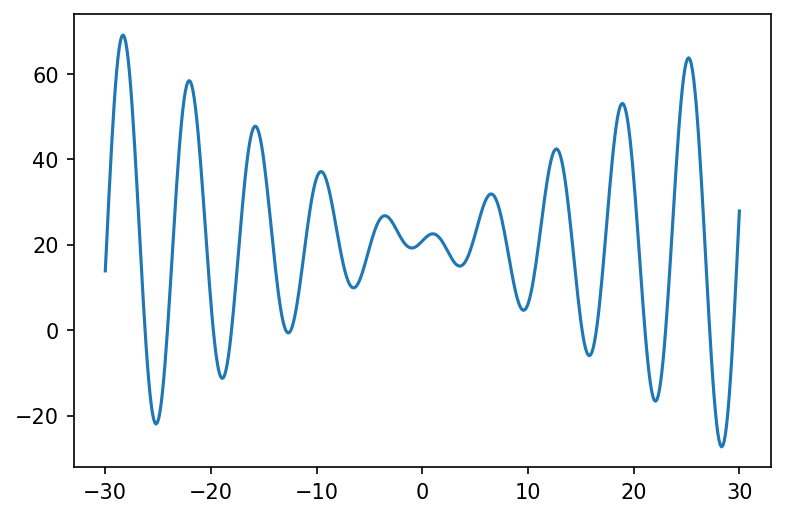

In [11]:
x_1 = np.linspace(-30,30,500)
M_knee = 0.054596 *5.74*0.174*0.174
C_knee = 5.74*0.174*0.4*np.sin(x_1)
G_theta = 5.74*9.8*0.174*0.174*np.cos(x_1)
d_time = 0.001
s_v = 0.0022/0.001
s_a = -4.92254*0.000001/0.001
new_loss = M_knee * s_a + C_knee * s_v+ G_theta * x_1 

# x_1 = np.linspace(-30,30,50)
y_1 =np.sin(x_1)+np.cos(x_1)+0.3*x_1+pow(x_1,2)
plt.rcParams['figure.dpi'] = 150
plt.plot(x_1 , new_loss)

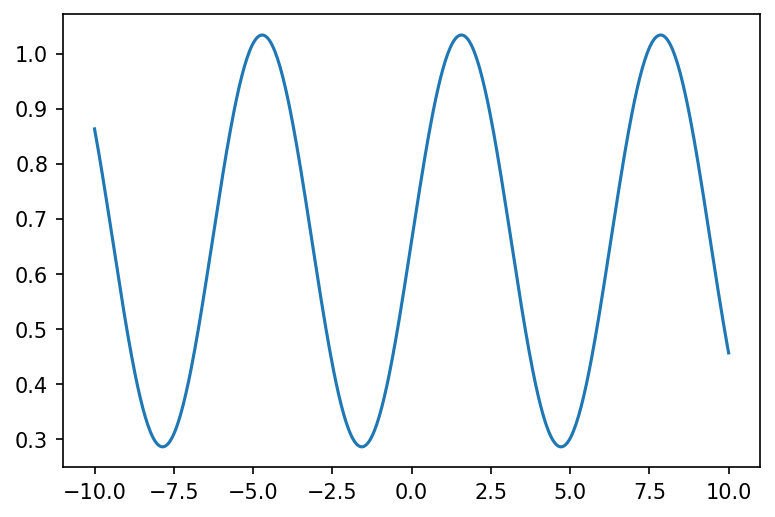

In [19]:
x_1 = np.linspace(-10,10,500)
M_knee = 0.054596 *5.74*0.174*0.174
C_knee = 5.74*0.174*0.4*np.sin(x_1)
G_theta = 5.74*9.8*0.174*0.174*np.cos(x_1)
d_time = 0.001
s_v = 0.0022/0.001
s_a = -4.92254*0.000001/0.001

s_I = (-13.68+0.088*78+0.092*178)/10000
s_mgl = 0.477*0.08*9.8
s_B = 0.3
new_loss = s_I * s_a + s_B * s_v+ s_mgl * np.sin(x_1) 

# x_1 = np.linspace(-30,30,50)
y_1 =np.sin(x_1)+np.cos(x_1)+0.3*x_1+pow(x_1,2)
y = pow(x_1,2) +new_loss
plt.rcParams['figure.dpi'] = 150
plt.plot(x_1 , new_loss)
# plt.plot(x_1 , y)